**今回の実習内容**
 * ビニング
 * フーリエクロップ
 * パディング
 * 実習課題

In [30]:
import sys,math,cmath,os,copy
import numpy as np
from numpy import fft
from scipy import ndimage
from matplotlib import pyplot as plt
import tifffile as tiff
import mrcfile as mrc

# OpenCV
import cv2

input image size:  300


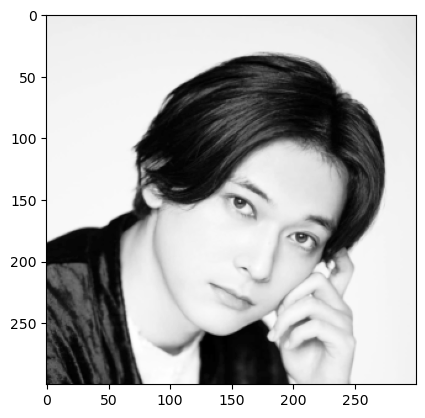

In [31]:
# テストデータの読み込み
fn_yoshi = "./data/course4_yoshizawa.tif"
yoshi = tiff.imread(fn_yoshi)

# オリジナルの画像サイズ(とその半分)
orisize = yoshi.shape[0]
halfori = int(orisize / 2)
print("input image size: ", orisize)

fig, ax = plt.subplots()

ax.imshow(yoshi, cmap='Greys')

**ビニングとフーリエクロップを比較してみる**
 * 実空間像と逆空間像、それぞれで違いを見る

In [ ]:
# 実空間でビニング
binfactor = 2

# ビニング後のサイズ
binsize = int(orisize / binfactor)

# ビニング後の配列を初期化
yoshi_bin = np.zeros((binsize,binsize))

# ビニング
for i in range(orisize):
    ibin = math.floor(i/binfactor)
    for j in range(orisize):
        jbin = math.floor(j/binfactor)

        yoshi_bin[ibin,jbin] += yoshi[i,j]

yoshi_bin /= binfactor

# ビニング前と比較(左がビニング後)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].imshow(yoshi_bin, cmap='Greys')
ax[1].imshow(yoshi, cmap='Greys')

In [ ]:
# 逆空間でのフーリエクロップ
# cryosparcと同様にクロップ後のサイズを指定
cropsize = 150   # should be even
halfcrop = int(cropsize / 2)

# 逆空間像を計算
rec_yoshi = fft.fft2(yoshi)

# クロップ後の逆空間像用の配列を初期化
rec_yoshi_crop = np.zeros((cropsize,cropsize),dtype=complex)

# クロップ
# np.fftでは逆空間中心が四隅になっていることに注意
rec_yoshi_crop[0:halfcrop,0:halfcrop] = rec_yoshi[0:halfcrop,0:halfcrop]               # 左上
rec_yoshi_crop[0:halfcrop,halfcrop:]  = rec_yoshi[0:halfcrop,orisize-halfcrop:]        # 右上
rec_yoshi_crop[halfcrop:,0:halfcrop]  = rec_yoshi[orisize-halfcrop:,0:halfcrop]        # 左下
rec_yoshi_crop[halfcrop:,halfcrop:]   = rec_yoshi[orisize-halfcrop:,orisize-halfcrop:] # 右下

# 逆フーリエ変換で実空間に戻す
yoshi_crop = fft.ifft2(rec_yoshi_crop).real

# クロップ前と比較(左がクロップ後)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].imshow(yoshi_crop, cmap='Greys')
ax[1].imshow(yoshi, cmap='Greys')

In [ ]:
# ビニング像とクロップ像を比較(実空間)

std_bin = np.std(yoshi_bin)
std_crop = np.std(yoshi_crop)

yoshi_crop /= (std_crop / std_bin)

diff_real = yoshi_bin - yoshi_crop

# ビニング像、クロップ像、差分
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

# 画素値の最大、最小が微妙に違うのでコントラストの付け方を統一
ax[0].imshow(yoshi_bin, cmap='Greys', vmin=-1.218, vmax=5.388)
ax[1].imshow(yoshi_crop, cmap='Greys', vmin=-1.218, vmax=5.388)
ax[2].imshow(diff_real, cmap='Greys', vmin=-1.218, vmax=5.388)

**パディング**
 * パディングの関数を定義
 * bガラクトシダーゼのスペックルを見てみる
 * 回転補間の精度を見てみる

In [2]:
# パディングの関数を定義しておく
def padding(image, factor):
    # paddingのサイズを定義
    padding_size = np.array([int(image.shape[0]*(factor-1)),int(image.shape[1]*(factor-1))])
    margin = np.array([int(padding_size[0]/2),int(padding_size[1]/2)])
    return cv2.copyMakeBorder(image, margin[1], margin[1], margin[0], margin[0], cv2.BORDER_CONSTANT, 0)

image size of bgal:  180  x  180
image size of padded bgal:  360  x  360
33.584217 0.0


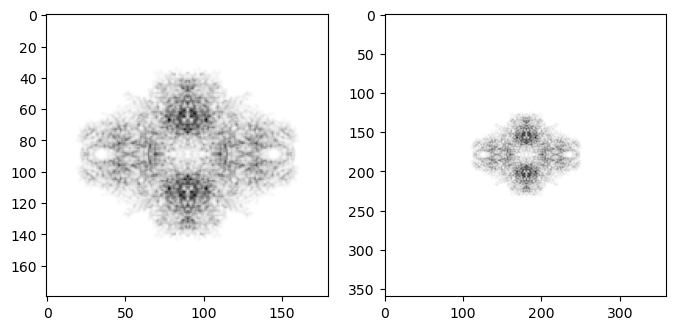

In [32]:
# まずはbgalの画像を読み込み
fn_bgal = "./data/course5_bgal.tif"

# bgalの投影像を読み込み
bgal = tiff.imread(fn_bgal)
print("image size of bgal: ", bgal.shape[0], " x ", bgal.shape[1])

# 先ほど定義した関数でpadding imageも作る
# 2倍にパディング
bgal_pad = padding(bgal, 2)
print("image size of padded bgal: ", bgal_pad.shape[0], " x ", bgal_pad.shape[1])

print(np.max(bgal),np.min(bgal))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].imshow(bgal, cmap='Greys')
ax[1].imshow(bgal_pad, cmap='Greys')

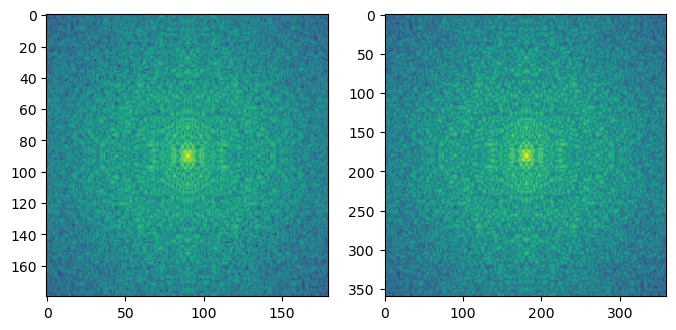

In [33]:
# 逆空間像のスペックルを比較してみる
rec_bgal = fft.fftshift(fft.fft2(bgal))
rec_bgal_pad = fft.fftshift(fft.fft2(bgal_pad))

ampl_bgal = np.abs(rec_bgal)
ampl_bgal_pad = np.abs(rec_bgal_pad)

second_min = np.unique(ampl_bgal)[1]
for i in range(rec_bgal.shape[0]):
    for j in range(rec_bgal.shape[1]):
        val = ampl_bgal[i,j]
        if val < second_min:
            ampl_bgal[i,j] = np.log(second_min)
        else:
            ampl_bgal[i,j] = np.log(ampl_bgal[i,j])

second_min = np.unique(ampl_bgal_pad)[1]
for i in range(rec_bgal_pad.shape[0]):
    for j in range(rec_bgal_pad.shape[1]):
        val = ampl_bgal_pad[i,j]
        if val < second_min:
            ampl_bgal_pad[i,j] = np.log(second_min)
        else:
            ampl_bgal_pad[i,j] = np.log(ampl_bgal_pad[i,j])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].imshow(ampl_bgal, cmap='viridis')
ax[1].imshow(ampl_bgal_pad, cmap='viridis') # パディングしても表示される逆空間像の範囲は同じ

<class 'numpy.complex64'>


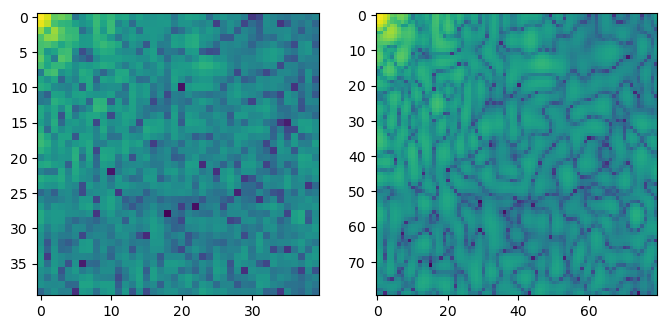

In [34]:
# よくわからんので逆空間像を拡大して比較

center = [int(rec_bgal.shape[0]/2),int(rec_bgal.shape[1]/2)]
print(type(rec_bgal[0,0]))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# 画像左上が逆空間中心
ax[0].imshow(ampl_bgal[center[0]:center[0]+40,center[1]:center[1]+40], cmap='viridis')
ax[1].imshow(ampl_bgal_pad[2*center[0]:2*(center[0]+40),2*center[1]:2*(center[1]+40)], cmap='viridis')

**逆空間での画像回転**
 * 実空間で元画像より画像を細かくすることは不可能
 * でも逆空間では可能

In [4]:
# 必要な関数として、FRC(Fourier Ring Correlation)を計算する関数を定義
# input: 逆空間像rec1とrec2(complexのnp.ndarray)
# また、rec1, rec2は画像中心が逆空間原点となっていると仮定
def calcFRC(rec1,rec2,frc):
    size = rec1.shape[0]
    center = np.array([(size/2)-0.5,(size/2)-0.5])

    
    frc = np.zeros(size/2)
    den1 = np.zeros(size/2)
    den2 = np.zeros(size/2)
    
    for i in range(rec1.shape[0]):
        kx = float(i) - center[0]
        for j in range(rec1.shape[0]):
            ky = float(j) - center[1]

            idx = int(np.sqrt(kx*kx + ky*ky))
            z1 = rec1[i,j]
            z2 = rec2[i,j]
            absz1 = np.abs(z1)
            absz2 = np.abs(z2)

            frc[idx] += (z1.conjugate() * z2).real        
            den1[idx] += absz1*absz1
            den2[idx] += absz2*absz2

    for i in range(np.shape[0]):
        frc[i] /= np.sqrt(den1[i]*den2[i])

    return

In [5]:
# クロッピングの関数を定義しておく
def cropping(image, factor=0, size=0):
    # croppingのサイズを定義
    cropping_size:int = 0
    if factor > 1:
        cropping_size = int(np.min(image.shape) * factor)
    elif size > 0 and size < np.min(image.shape):
        cropping_size = int(size)
    else:
        print("Error: invalid cropping size")
        sys.exit()

    margin = np.array([int((image.shape[0]-cropping_size)/2),int((image.shape[1]-cropping_size)/2)])

    return copy.deepcopy(image[margin[0]:image.shape[0]-margin[0],margin[1]:image.shape[1]-margin[1]])    

In [ ]:
# bgalの像を逆空間上で20度回転してみる
# 画像回転は02_correlationで説明

theta = 45

# paddingなし
xsize = rec_bgal.shape[0]
ysize = rec_bgal.shape[1]
kcenter = np.array([(xsize/2)-0.5,(ysize/2)-0.5])
center = np.array([int(xsize/2),int(ysize/2)])
rot = cv2.getRotationMatrix2D(kcenter, theta, 1.0)

# 実部、虚部をそれぞれ回転
rec_bgal_rot_real = cv2.warpAffine(rec_bgal.real, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)
rec_bgal_rot_imag = cv2.warpAffine(rec_bgal.imag, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)

# 回転後の画像を初期化
rec_bgal_rot = np.zeros(rec_bgal.shape,dtype=complex)
#for i1 in range(center[0]):
#    i2 = (xsize - center[0]) + (center[0] - i1 - 1)
#    for j1 in range(rec_bgal.shape[1]):
#        j2 = (ysize - center[1]) + (center[1] - j1 - 1)
#        ave_real = (rec_bgal_rot_real[i1,j1] + rec_bgal_rot_real[i2,j2]) / 2.
#        ave_imag = (rec_bgal_rot_imag[i1,j1] + rec_bgal_rot_imag[i2,j2]) / 2.
#        rec_bgal_rot[i1,j1] = complex(ave_real,ave_imag)
#        rec_bgal_rot[i2,j2] = complex(ave_real,ave_imag)

for i in range(rec_bgal.shape[0]):
    for j in range(rec_bgal.shape[1]):
        rec_bgal_rot[i,j] = complex(rec_bgal_rot_real[i,j],rec_bgal_rot_imag[i,j])

# paddingあり
xsize = rec_bgal_pad.shape[0]
ysize = rec_bgal_pad.shape[1]
center = np.array([(xsize/2)-0.5,(ysize/2)-0.5])
rot = cv2.getRotationMatrix2D((((xsize/2.)-0.5, (ysize/2.)-0.5)), theta, 1.0)

edge_width = 3
for i in range(rec_bgal_pad.shape[0]):
    kx = float(i) - center[0]
    for j in range(rec_bgal_pad.shape[0]):
        ky = float(j) - center[1]

        idx = int(np.sqrt(kx*kx + ky*ky))
        if (idx > xsize/2):
            rec_bgal_pad[i,j] *= np.cos((idx - xsize/2) * (np.pi/(2*edge_width)))

# 実部、虚部をそれぞれ回転
rec_bgal_pad_rot_real = cv2.warpAffine(rec_bgal_pad.real, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)
rec_bgal_pad_rot_imag = cv2.warpAffine(rec_bgal_pad.imag, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)

# 回転後の画像を初期化
rec_bgal_pad_rot = np.zeros(rec_bgal_pad.shape,dtype=complex)
for i in range(rec_bgal_pad.shape[0]):
    for j in range(rec_bgal_pad.shape[1]):
        rec_bgal_pad_rot[i,j] = complex(rec_bgal_pad_rot_real[i,j],rec_bgal_pad_rot_imag[i,j])

bgal_rot = fft.ifft2(fft.ifftshift(rec_bgal_rot)).real
bgal_pad_rot = fft.ifft2(fft.ifftshift(rec_bgal_pad_rot)).real

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].imshow(bgal_rot, cmap='Greys')
# 比較のためにパディングした像をクロップして元に戻す
margin=90
bgal_pad_rot_crop = bgal_pad_rot[margin:bgal.shape[0]+margin,margin:bgal.shape[1]+margin]
#ax[1].imshow(bgal_pad_rot_crop, cmap='Greys')
ax[1].imshow(bgal_pad_rot, cmap='Greys')


In [ ]:
# bgalの像を逆空間上で20度回転してみる
# 画像回転は02_correlationで説明

theta = 180

# paddingなし
xsize = rec_bgal.shape[0]
ysize = rec_bgal.shape[1]
kcenter = np.array([(xsize/2)-0.5,(ysize/2)-0.5])
center = np.array([int(xsize/2),int(ysize/2)])
rot = cv2.getRotationMatrix2D(kcenter, theta, 1.0)

# 実部、虚部をそれぞれ回転
rec_bgal_rot_real = cv2.warpAffine(rec_bgal.real, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)
rec_bgal_rot_imag = cv2.warpAffine(rec_bgal.imag, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)

# 回転後の画像を初期化
rec_bgal_rot = np.zeros(rec_bgal.shape,dtype=complex)

for i in range(rec_bgal.shape[0]):
    for j in range(rec_bgal.shape[1]):
        rec_bgal_rot[i,j] = complex(rec_bgal_rot_real[i,j],rec_bgal_rot_imag[i,j])

rec_bgal_rot_shift = fft.ifftshift(rec_bgal_rot)

phase = np.zeros(rec_bgal.shape)
for i in range(rec_bgal.shape[0]):
    for j in range(rec_bgal.shape[1]):
        phase[i,j] = cmath.phase(rec_bgal[i,j])

ampl_bgal = np.abs(rec_bgal_rot)

second_min = np.unique(ampl_bgal)[1]
for i in range(rec_bgal_rot_shift.shape[0]):
    for j in range(rec_bgal_rot_shift.shape[1]):
        val = ampl_bgal[i,j]
        if val < second_min:
            ampl_bgal[i,j] = np.log(second_min)
        else:
            ampl_bgal[i,j] = np.log(ampl_bgal[i,j])

phase_rot = np.zeros(rec_bgal_rot.shape)
for i in range(rec_bgal_rot.shape[0]):
    for j in range(rec_bgal_rot.shape[1]):
        phase_rot[i,j] = cmath.phase(rec_bgal_rot[i,j])

bgal_rot = fft.ifft2(rec_bgal_rot_shift).real 

#rec_bgal_rot_shift_quat = np.zeros(rec_bgal_rot.shape, dtype=complex)
#for i in range(center[0]):
#    for j in range(center[1]):
#        rec_bgal_rot_shift_quat[i,j] = rec_bgal_rot_shift[i,j]

#bgal_rot_shift_quat = fft.ifft2(rec_bgal_rot_shift_quat).real

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

#ax[0].imshow(phase, cmap='twilight')
# 比較のためにパディングした像をクロップして元に戻す
phase_crop = phase[40:140,40:140]
phase_rot_crop = phase_rot[40:140,40:140]
#ax[0].imshow(phase_crop, cmap='twilight')
#ax[1].imshow(phase_rot_crop, cmap='twilight')
ax[0].imshow(bgal_rot, cmap='Greys')
ax[1].imshow(phase_rot, cmap='twilight')


In [ ]:
# bgalの像を逆空間上で20度回転してみる
# 画像回転は02_correlationで説明

theta = 20

# paddingなし
xsize = rec_bgal.shape[0]
ysize = rec_bgal.shape[1]
kcenter = np.array([(xsize/2)-0.5,(ysize/2)-0.5])
center = np.array([int(xsize/2),int(ysize/2)])
rot = cv2.getRotationMatrix2D(kcenter, theta, 1.0)

rec_bgal_ampl = np.abs(rec_bgal)
rec_bgal_phase = np.zeros(rec_bgal.shape)
for i in range(rec_bgal.shape[0]):
    for j in range(rec_bgal.shape[1]):
        rec_bgal_phase[i,j] = cmath.phase(rec_bgal[i,j])

# 実部、虚部をそれぞれ回転
rec_bgal_rot_ampl = cv2.warpAffine(rec_bgal_ampl, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)
rec_bgal_rot_phase = cv2.warpAffine(rec_bgal_phase, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)

# 回転後の画像を初期化
rec_bgal_rot = np.zeros(rec_bgal.shape,dtype=complex)

for i in range(rec_bgal.shape[0]):
    for j in range(rec_bgal.shape[1]):
        rec_bgal_rot[j,i] = complex(np.cos(rec_bgal_rot_phase[j,i]),np.sin(rec_bgal_rot_phase[j,i]))
        rec_bgal_rot[j,i] *= rec_bgal_rot_ampl[j,i]

rec_bgal_rot_shift = fft.fftshift(rec_bgal_rot)

phase = np.zeros(rec_bgal.shape)
for i in range(rec_bgal.shape[0]):
    for j in range(rec_bgal.shape[1]):
        phase[i,j] = cmath.phase(rec_bgal[i,j])

ampl_bgal = np.abs(rec_bgal_rot)

second_min = np.unique(ampl_bgal)[1]
for i in range(rec_bgal_rot_shift.shape[0]):
    for j in range(rec_bgal_rot_shift.shape[1]):
        val = ampl_bgal[i,j]
        if val < second_min:
            ampl_bgal[i,j] = np.log(second_min)
        else:
            ampl_bgal[i,j] = np.log(ampl_bgal[i,j])

phase_rot = np.zeros(rec_bgal_rot.shape)
phase_rot_shift = np.zeros(rec_bgal_rot.shape)
for i in range(rec_bgal_rot.shape[0]):
    for j in range(rec_bgal_rot.shape[1]):
        phase_rot[i,j] = cmath.phase(rec_bgal_rot[i,j])
        phase_rot_shift[i,j] = cmath.phase(rec_bgal_rot_shift[i,j])

bgal_rot = fft.ifft2(rec_bgal_rot_shift).real

#rec_bgal_rot_shift_quat = np.zeros(rec_bgal_rot.shape, dtype=complex)
#for i in range(center[0]):
#    for j in range(center[1]):
#        rec_bgal_rot_shift_quat[i,j] = rec_bgal_rot_shift[i,j]

#bgal_rot_shift_quat = fft.ifft2(rec_bgal_rot_shift_quat).real

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

#ax[0].imshow(phase, cmap='twilight')
# 比較のためにパディングした像をクロップして元に戻す
phase_crop = phase[40:140,40:140]
phase_rot_crop = phase_rot[40:140,40:140]
#ax[0].imshow(phase_crop, cmap='twilight')
#ax[1].imshow(phase_rot_crop, cmap='twilight')
#ax[0].imshow(bgal_rot, cmap='Greys')
ax[0].imshow(phase_rot, cmap='twilight')
ax[1].imshow(phase_rot_shift, cmap='twilight')

In [ ]:
# bgalの像を逆空間上で20度回転してみる
# 画像回転は02_correlationで説明

theta = 20

# paddingなし
xsize = bgal.shape[0]
ysize = bgal.shape[1]
kcenter = np.array([(xsize/2)-0.5,(ysize/2)-0.5])
rot = cv2.getRotationMatrix2D(kcenter, theta, 1.0)

bgal_rot = cv2.warpAffine(bgal, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)
rec_bgal_rot = fft.fftshift(fft.fft2(bgal_rot))

ampl_bgal = np.abs(rec_bgal_rot)

second_min = np.unique(ampl_bgal)[1]
for i in range(rec_bgal_rot_shift.shape[0]):
    for j in range(rec_bgal_rot_shift.shape[1]):
        val = ampl_bgal[i,j]
        if val < second_min:
            ampl_bgal[i,j] = np.log(second_min)
        else:
            ampl_bgal[i,j] = np.log(ampl_bgal[i,j])

phase_rot = np.zeros(rec_bgal_rot.shape)
for i in range(rec_bgal_rot.shape[0]):
    for j in range(rec_bgal_rot.shape[1]):
        phase_rot[i,j] = cmath.phase(rec_bgal_rot[i,j])

#rec_bgal_rot_shift_quat = np.zeros(rec_bgal_rot.shape, dtype=complex)
#for i in range(center[0]):
#    for j in range(center[1]):
#        rec_bgal_rot_shift_quat[i,j] = rec_bgal_rot_shift[i,j]

#bgal_rot_shift_quat = fft.ifft2(rec_bgal_rot_shift_quat).real

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

#ax[0].imshow(phase, cmap='twilight')
# 比較のためにパディングした像をクロップして元に戻す
phase_crop = phase[40:140,40:140]
phase_rot_crop = phase_rot[40:140,40:140]
#ax[0].imshow(phase_crop, cmap='twilight')
#ax[1].imshow(phase_rot_crop, cmap='twilight')
#ax[0].imshow(bgal_rot, cmap='Greys')
ax[0].imshow(bgal_rot, cmap='Greys')
ax[1].imshow(phase_rot, cmap='twilight')

In [6]:
# 線形補間の関数を定義しておく

def linterp(frac, low, high):
    return low + (high - low) * frac

In [7]:
# 角度をラジアンに変換する関数も定義
def deg2rad(deg):
    return deg * np.pi / 180.

In [8]:
# オイラー角から回転行列を与える
# 二次元平面上の回転であっても三次元回転行列で扱う
# 
def getRotationMatrix(A, rot=0, tilt=0, psi=0):
    rot  = deg2rad(rot)
    tilt = deg2rad(tilt)
    psi  = deg2rad(psi)

    ca = np.cos(rot)
    cb = np.cos(tilt)
    cg = np.cos(psi)
    sa = np.sin(rot)
    sb = np.sin(tilt)
    sg = np.sin(psi)
    cc = cb * ca
    cs = cb * sa
    sc = sb * ca
    ss = sb * sa

    A[0, 0] =  cg * cc - sg * sa
    A[0, 1] =  cg * cs + sg * ca
    A[0, 2] = -cg * sb
    A[1, 0] = -sg * cc - cg * sa
    A[1, 1] = -sg * cs + cg * ca
    A[1, 2] = sg * sb
    A[2, 0] = sc
    A[2, 1] = ss
    A[2, 2] = cb

    return

In [9]:
# 回転行列から回転後の投影像を計算する
# 引数
# image: 2D ndarray (二次元像)
# image: 2D ndarray (二次元像)
# a3d: 2D ndarray (回転行列)

# 返り値はないがrotimageが更新される

def rotate2D(image, rotimage, a3d, factor=1):

    debug = True

    # inverse the input rotation matrix a3d (a3d^-1 = a3d^T)
    # 余裕のある人はなぜ逆行列にするか考えてみてください
    ainv = a3d.T
    #ainv *= int(factor)
    
    if debug:
        print('a3d_inv:')
        print(ainv)

    if factor > 1:
        image = padding(image, factor=factor)
    
    # imageの逆空間像を計算
    rec_image = fft.fftshift(fft.fft2(image))

    # 0 = z, 1 = y, 2 = x
    boxsize = rec_image.shape

    if debug:
        print('boxsize: ', boxsize)

    # boxの内接球の領域だけを計算する
    # そのための最大半径を定義
    _radius = np.zeros(2, dtype=int)
    for i in range(2):
        _radius[i] = math.floor(boxsize[i] / 2) - 1

    if debug:
        print('_radius: ', _radius)

    _rmax_out: int = _radius.min()
    _rmax_out_2: int = _rmax_out * _rmax_out;

    _rmax_ref: int = _rmax_out * int(factor)
    _rmax_ref_2: int = _rmax_ref * _rmax_ref

    if debug:
        print('_rmax_out: ', _rmax_out)
        print('_rmax_out_2: ', _rmax_out_2)

    # 回転後の逆空間像を定義
    rec_image_rot = np.zeros(rec_image.shape, dtype=complex)
    
    # loop for y-axis component
    for j in range(boxsize[0]):

        y: int = 0

        # boxsizeが奇数かどうかで場合分け
        if boxsize[0] % 2 == 0:
            y = j - _radius[0] if j <= _radius[0] else j - (_radius[0] + 1)
        else:
            y = j - (_radius[0] + 1)

        y2 = y * y

        if (y2 > _rmax_out_2): continue

        # xmax depends on current z and y
        xmax = math.floor(math.sqrt(_rmax_out_2 - y2)) 

        # loop for x-axis component
        for i in range(boxsize[1]):

            x: int = 0
            
            # boxsizeが奇数かどうかで場合分け
            if boxsize[1] % 2 == 0:
                x = i - _radius[1] if i <= _radius[1] else i - (_radius[1] + 1)
            else:
                x = i - (_radius[1] + 1)

            if x * x > xmax * xmax: continue

            xp = ainv[0,0] * x + ainv[0,1] * y
            yp = ainv[1,0] * x + ainv[1,1] * y

            r_ref2: int = xp*xp + yp*yp

            if (r_ref2 > _rmax_ref_2): continue

            # define nearest gridding coordinates
            x0 = math.floor(xp)
            fx = xp - x0
            if boxsize[0] % 2 == 0:
                x0 += _radius[0]
            else:
                x0 += _radius[0] + 1                    
            x1 = x0 + 1

            y0 = math.floor(yp)
            fy = yp - y0
            if boxsize[1] % 2 == 0:
                y0 += _radius[1]
            else:
                y0 += _radius[1] + 1
            y1 = y0 + 1

            if x0 < 0 or x0+1 >= boxsize[0] or y0 < 0 or y0+1 >= boxsize[1]:
                continue

            d00 = rec_image[y0,x0]
            d01 = rec_image[y0,x1]
            d10 = rec_image[y1,x0]
            d11 = rec_image[y1,x1]

            dx0 = linterp(fx, d00, d01)
            dx1 = linterp(fx, d10, d11)

            rec_image_rot[j,i] = linterp(fy, dx0, dx1)

    if (factor > 1):
        rotimage = copy.deepcopy(cropping(fft.ifft2(fft.ifftshift(rec_image_rot)).real, factor=factor))
    elif (factor == 1):
        rotimage = copy.deepcopy(fft.ifft2(fft.ifftshift(rec_image_rot)).real)

    plt.imshow(rotimage, cmap='Greys')
    
    return

a3d_inv:
[[ 0.93969262 -0.34202014  0.        ]
 [ 0.34202014  0.93969262  0.        ]
 [-0.          0.          1.        ]]
boxsize:  (360, 360)
_radius:  [179 179]
_rmax_out:  179
_rmax_out_2:  32041


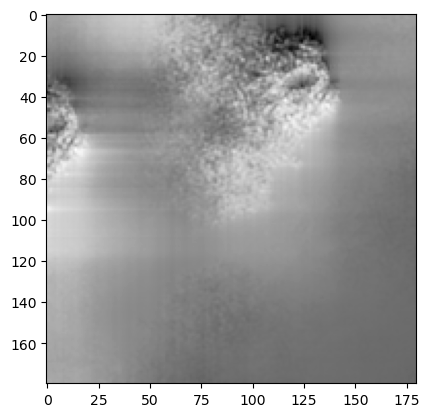

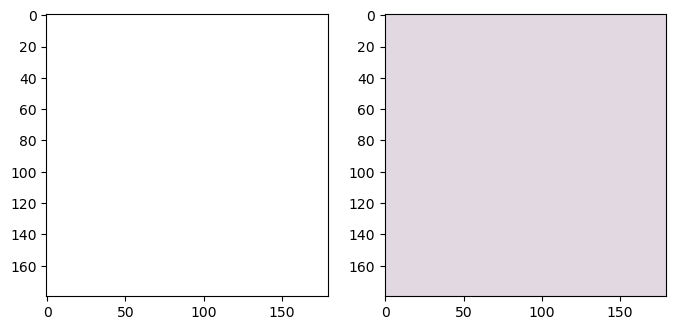

In [10]:
# bgalの像を逆空間上で20度回転してみる
# 画像回転は02_correlationで説明

psi = 20

A = np.zeros((3,3))
getRotationMatrix(A, rot=0, tilt=0, psi=psi)

bgal_rot = np.zeros(bgal.shape)

rotate2D(bgal, bgal_rot, A, factor=2)

rec_bgal_rot = fft.fftshift(fft.fft2(bgal_rot))

phase_rot = np.zeros(rec_bgal_rot.shape)
for i in range(rec_bgal_rot.shape[0]):
    for j in range(rec_bgal_rot.shape[1]):
        phase_rot[i,j] = cmath.phase(rec_bgal_rot[i,j])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].imshow(bgal_rot, cmap='Greys')
ax[1].imshow(phase_rot, cmap='twilight')

In [11]:
# 2次元逆空間像を回転させる関数
# data: 回転前の像
# rotdata: 回転後の像
# A3d: 回転行列
# factor: パディング、クロッピングの倍率
def rotate2D(data, rotdata, A3d, factor=1):
    debug = True

    if (data.shape[0] != rotdata.shape[0] or data.shape[1] != rotdata.shape[1]):
        print('Error: input and output array must have the same shape!')
        sys.exit()

    # define rotation matrix (inversede)
    # and correct the scaling by multiplying padding factor
    Ainv = A3d.T
    Ainv *= int(factor)

    # 0 = z, 1 = y, 2 = x
    boxsize = data.shape

    if debug:
        print('boxsize: ', boxsize)

    # boxの内接球の領域だけを計算する
    # そのための最大半径を定義
    radius = np.zeros(2, dtype=int)
    for i in range(2):
        radius[i] = math.floor(boxsize[i] / 2) - 1

    if debug:
        print('radius: ', radius)

    rmax_out: int = radius.min()

    rmax_ref: int = rmax_out * int(factor)
    rmax_ref_2: int = rmax_ref * rmax_ref

    if (debug):
        print('rmax_ref_2: ', rmax_ref_2)

    # define starting to access logical coordinates
    starting = np.array([1 - boxsize[0]/2, 1 - boxsize[1]/2], dtype=int)
    
    for i in range(data.shape[0]):
        y = i + starting[0]

        for j in range(data.shape[1]):
            x = j + starting[1]

            # 画像中心を原点とした座標にシフトさせる
            xu = x - 0.5
            yu = y - 0.5

            xp = Ainv[0,0] * xu + Ainv[0,1] * yu
            yp = Ainv[1,0] * xu + Ainv[1,1] * yu

            r_ref_2 = xp * xp + yp * yp
            if (r_ref_2 > rmax_ref_2):
                continue
            
            y0 = np.floor(yp + 0.5)
            fy = yp + 0.5 - y0
            y0 -= starting[0]
            y1:int = y0 + 1

            x0:int = np.floor(xp + 0.5)
            fx = xp + 0.5 - x0
            x0 -= starting[1]
            x1 = x0 + 1

            d00 = data[int(y0),int(x0)]
            d01 = data[int(y0),int(x1)]
            d10 = data[int(y1),int(x0)]
            d11 = data[int(y1),int(x1)]

            dx0 = linterp(fx, d00, d01)
            dx1 = linterp(fx, d10, d11)

            rotdata[i,j] = linterp(fy, dx0, dx1)

    return

In [12]:
# 2次元逆空間像を回転させる関数
# data: 回転前の像
# rotdata: 回転後の像
# A3d: 回転行列
# factor: パディング、クロッピングの倍率
def backRotate2D(data, rotdata, A3d, factor=1):
    debug = True

    if (data.shape[0] != rotdata.shape[0] or data.shape[1] != rotdata.shape[1]):
        print('Error: input and output array must have the same shape!')
        sys.exit()

    # define rotation matrix (inversede)
    # and correct the scaling by multiplying padding factor
    Ainv = A3d.T
    Ainv *= int(factor)

    # 0 = z, 1 = y, 2 = x
    boxsize = data.shape

    if debug:
        print('boxsize: ', boxsize)

    # boxの内接球の領域だけを計算する
    # そのための最大半径を定義
    radius = np.zeros(2, dtype=int)
    for i in range(2):
        radius[i] = math.floor(boxsize[i] / 2) - 1

    if debug:
        print('radius: ', radius)

    rmax_out: int = radius.min()

    rmax_ref: int = rmax_out * int(factor)
    rmax_ref_2: int = rmax_ref * rmax_ref

    if (debug):
        print('rmax_ref_2: ', rmax_ref_2)
    
    AtA_xx  = Ainv[0,0] * Ainv[0,0] + Ainv[1,0] * Ainv[1,0]
    AtA_xy  = Ainv[0,0] * Ainv[0,1] + Ainv[1,0] * Ainv[1,1]
    AtA_yy  = Ainv[0,1] * Ainv[0,1] + Ainv[1,1] * Ainv[1,1]
    AtA_xy2 = AtA_xy * AtA_xy

    # define starting to access logical coordinates
    starting = np.array([1 - boxsize[0]/2, 1 - boxsize[1]/2], dtype=int)
    
    for i in range(data.shape[0]):
        y = i + starting[0]

        discr = AtA_xy2 * y*y - AtA_xx * (AtA_yy * y*y - rmax_ref_2)
        if (discr < 0.0):
            continue

        d = np.sqrt(discr) / AtA_xx
        q = - AtA_xy * y / AtA_xx
        
        for j in range(data.shape[1]):
            x = j + starting[1]

            # dataのピクセル値を読み込み
            myval = data[i,j]

            # 画像中心を原点とした座標にシフトさせる
            xu = x - 0.5
            yu = y - 0.5

            xp = Ainv[0,0] * xu + Ainv[0,1] * yu
            yp = Ainv[1,0] * xu + Ainv[1,1] * yu

            r_ref_2 = xp * xp + yp * yp
            if (r_ref_2 > rmax_ref_2):
                continue

            y0 = np.floor(yp + 0.5)
            fy = yp + 0.5 - y0
            y0 -= starting[0]
            y1:int = y0 + 1

            x0:int = np.floor(xp + 0.5)
            fx = xp + 0.5 - x0
            x0 -= starting[1]
            x1 = x0 + 1

            mfx = 1. - fx
            mfy = 1. - fy

            dd00 = mfy * mfx
            dd01 = mfy *  fx
            dd10 =  fy * mfx
            dd11 =  fy *  fx

            # Store slice in 3D weighted sum
            rotdata[int(y0),int(x0)] += dd00 * myval
            rotdata[int(y0),int(x1)] += dd01 * myval
            rotdata[int(y1),int(x0)] += dd10 * myval
            rotdata[int(y1),int(x1)] += dd11 * myval

    return

In [13]:
def centerFFT(image, forward):

    l = image.shape[1]
    aux = np.zeros(l)
    shift = int(l / 2)

    if not forward:
        shift *= -1

    for i in range(image.shape[0]):
        for j in range(l):
            jp = j + shift
            if jp < 0:
                jp += l
            elif jp >= l:
                jp -= l

            aux[int(jp)] = image[i,j]

        for j in range(l):
            image[i,j] = aux[j]

    l = image.shape[0]
    aux = np.zeros(l)
    shift = int(l / 2)

    if not forward:
        shift *= -1

    for j in range(image.shape[1]):
        for i in range(l):
            ip = i + shift
            if ip < 0:
                ip += l
            elif ip >= l:
                ip -= l

            aux[int(ip)] = image[i,j]

        for i in range(l):
            image[i,j] = aux[i]

    return

[[-0.5        0.8660254  0.       ]
 [-0.8660254 -0.5        0.       ]
 [ 0.         0.         1.       ]]
6.270826296058575 -6.264358951043147


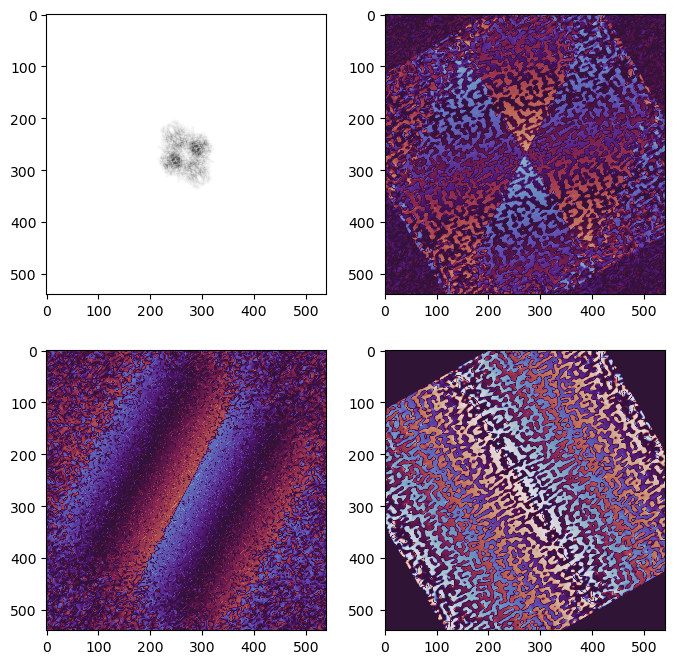

In [27]:
# 2次元回転のテスト
# bgalの像を逆空間上で20度回転してみる
# 画像回転は02_correlationで説明

bgal = tiff.imread(fn_bgal)

psi = 120

A = np.zeros((3,3))
getRotationMatrix(A, rot=0, tilt=0, psi=psi)

print(A)

bgal = np.pad(bgal, (180,180))

rec_bgal = fft.fftshift(fft.fft2(fft.fftshift(bgal)))

#rec_bgal_rot = np.zeros(rec_bgal.shape, dtype=complex)

rec_bgal_rot = ndimage.rotate(rec_bgal, psi, reshape=False)
#rotate2D(rec_bgal, rec_bgal_rot, A, factor=1)
#backRotate2D(rec_bgal, rec_bgal_rot, A, factor=1)

bgal_rot = fft.ifftshift(fft.ifft2(fft.ifftshift(rec_bgal_rot))).real

xsize = bgal.shape[0]
ysize = bgal.shape[1]
kcenter = np.array([(xsize/2)-0.5,(ysize/2)-0.5])
rot = cv2.getRotationMatrix2D(kcenter, psi, 1.0)
bgal_cvrot = cv2.warpAffine(bgal, rot, (xsize, ysize), flags=cv2.INTER_LINEAR)

rec_bgal_cvrot = fft.fftshift(fft.fft2(bgal_cvrot))

#centerFFT(bgal_rot, forward=False)

ampl = np.abs(rec_bgal_rot)
second_min = np.unique(ampl)[1]
for i in range(rec_bgal_rot.shape[0]):
    for j in range(rec_bgal_rot.shape[1]):
        val = ampl[i,j]
        if val < second_min:
            ampl[i,j] = np.log(second_min)
        else:
            ampl[i,j] = np.log(ampl[i,j])

phase_rot = np.zeros(rec_bgal_rot.shape)
phase_cvrot = np.zeros(rec_bgal_rot.shape)
phase_diff = np.zeros(rec_bgal_rot.shape)
for i in range(rec_bgal_rot.shape[0]):
    for j in range(rec_bgal_rot.shape[1]):
        phase_rot[i,j] = cmath.phase(rec_bgal_rot[i,j])
        phase_cvrot[i,j] = cmath.phase(rec_bgal_cvrot[i,j])
        phase_diff[i,j] = phase_cvrot[i,j] - phase_rot[i,j]

print(np.max(phase_diff), np.min(phase_diff))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

#ax[0,0].imshow(bgal, cmap='Greys', vmax=34, vmin=0)
ax[0,0].imshow(bgal_rot, cmap='Greys', vmax=34, vmin=0)
ax[0,1].imshow(phase_diff, cmap='twilight')

ax[1,0].imshow(phase_cvrot, cmap='twilight')
#ax[1,0].imshow(ampl, cmap='viridis')
ax[1,1].imshow(phase_rot, cmap='twilight')

In [ ]:
# 2次元回転のテスト
# bgalの像を逆空間上で20度回転してみる
# 画像回転は02_correlationで説明

psi = 90

A = np.zeros((3,3))
getRotationMatrix(A, rot=0, tilt=0, psi=psi)

test = np.zeros((6,6))
test[2,4] = 10
rec_test = fft.fftshift(fft.fft2(test))

mask = np.zeros(test.shape)
x = np.arange(6,dtype=float)
y = np.arange(6,dtype=float)
ymat,xmat = np.meshgrid(y,x)

ymat -= 2.5
xmat -= 2.5

print(ymat)

rmat = ymat ** 2 + xmat **2
print(rmat)
mask = np.where(rmat > 2.5,0.0,1.0)
print(mask)

rec_test_rot = np.zeros(rec_test.shape, dtype=complex)


rotate2D(rec_test, rec_test_rot, A, factor=1)

rec_test *= mask
print('rec_test')
for i in range(test.shape[0]):
    line = '['
    for j in range(test.shape[1]):
        line += '['
        line += "%5.2f+%5.2fj"%(rec_test[i,j].real,rec_test[i,j].imag)
        line += '] '
    line += ']\n'
    print(line)

print('rec_test_rot')
for i in range(test.shape[0]):
    line = '['
    for j in range(test.shape[1]):
        line += '['
        line += "%5.2f+%5.2fj"%(rec_test_rot[i,j].real,rec_test_rot[i,j].imag)
        line += '] '
    line += ']\n'
    print(line)

#test_rot = fft.ifft2(fft.ifftshift(rec_test_rot)).real

rot = cv2.getRotationMatrix2D([2.5,2.5], psi, 1.0)
test_rot = np.zeros(test.shape)
test_rot = cv2.warpAffine(test, rot, (6, 6), flags=cv2.INTER_LINEAR)
rec = fft.fftshift(fft.fft2(test_rot))
rec *= mask
print('rec')
for i in range(test.shape[0]):
    line = '['
    for j in range(test.shape[1]):
        line += '['
        line += "%5.2f+%5.2fj"%(rec[i,j].real,rec[i,j].imag)
        line += '] '
    line += ']\n'
    print(line)


ampl = np.abs(rec_test_rot)
second_min = np.unique(ampl)[1]
for i in range(rec_test_rot.shape[0]):
    for j in range(rec_test_rot.shape[1]):
        val = ampl[i,j]
        if val < second_min:
            ampl[i,j] = np.log(second_min)
        else:
            ampl[i,j] = np.log(ampl[i,j])

phase = np.zeros(rec_test.shape)
for i in range(rec_test_rot.shape[0]):
    for j in range(rec_test_rot.shape[1]):
        phase[i,j] = cmath.phase(rec_test_rot[i,j]) - cmath.phase(rec[i,j])

phase *= mask

print('phase diff')
for i in range(test.shape[0]):
    line = '['
    for j in range(test.shape[1]):
        line += '['
        line += "%5.2f"%(phase[i,j])
        line += '] '
    line += ']\n'
    print(line)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ax[0,0].imshow(test, cmap='Greys', vmax=10, vmin=0)
ax[0,1].imshow(test_rot, cmap='Greys')
#ax[1,0].imshow(ampl, cmap='viridis')
#ax[1,1].imshow(phase, cmap='twilight')

boxsize:  (80, 80)
radius:  [39 39]
rmax_ref_2:  1521
0.0


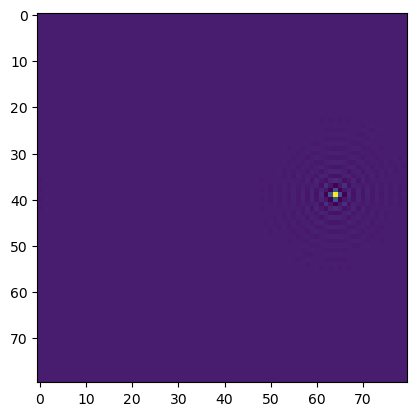

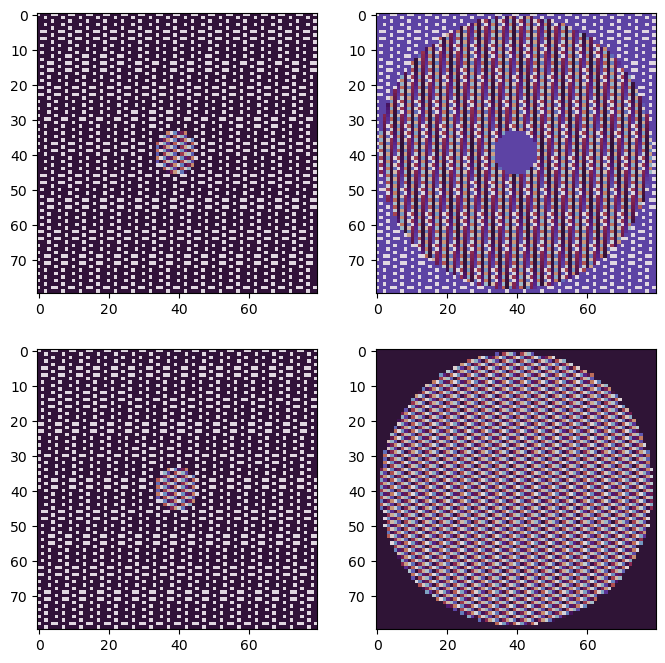

In [15]:
# 2次元回転のテスト
# bgalの像を逆空間上で20度回転してみる
# 画像回転は02_correlationで説明

psi = 0

A = np.zeros((3,3))
getRotationMatrix(A, rot=0, tilt=0, psi=psi)

test = np.zeros((80,80))
test[39,64] = 10
rec_test = fft.fftshift(fft.fft2(test))

mask = np.zeros(test.shape)
x = np.arange(80,dtype=float)
y = np.arange(80,dtype=float)
ymat,xmat = np.meshgrid(y,x)

ymat -= 39.5
xmat -= 39.5

rmat = ymat ** 2 + xmat **2
mask = np.where(rmat > 39.5,0.0,1.0)

rec_test_rot = np.zeros(rec_test.shape, dtype=complex)

rotate2D(rec_test, rec_test_rot, A, factor=1)

test_rot = fft.ifft2(fft.ifftshift(rec_test_rot)).real

rec_test *= mask

rot = cv2.getRotationMatrix2D([39.5,39.5], psi, 1.0)
test_cvrot = np.zeros(test.shape)
test_cvrot = cv2.warpAffine(test, rot, (80, 80), flags=cv2.INTER_LINEAR)
rec_test_cvrot = fft.fftshift(fft.fft2(test_cvrot))
rec_test_cvrot *= mask

ampl = np.abs(rec_test_rot)
second_min = np.unique(ampl)[1]
for i in range(rec_test_rot.shape[0]):
    for j in range(rec_test_rot.shape[1]):
        val = ampl[i,j]
        if val < second_min:
            ampl[i,j] = np.log(second_min)
        else:
            ampl[i,j] = np.log(ampl[i,j])

phase = np.zeros(rec_test.shape)
phase_rot = np.zeros(rec_test.shape)
phase_cvrot = np.zeros(rec_test.shape)
phase_diff = np.zeros(rec_test.shape)
for i in range(rec_test_rot.shape[0]):
    for j in range(rec_test_rot.shape[1]):
        phase[i,j] = cmath.phase(rec_test[i,j])
        phase_rot[i,j] = cmath.phase(rec_test_rot[i,j])
        phase_cvrot[i,j] = cmath.phase(rec_test_cvrot[i,j])
        phase_diff[i,j] = cmath.phase(rec_test_cvrot[i,j]) - cmath.phase(rec_test_rot[i,j])

print(phase_diff[40,40])

plt.imshow(test_rot)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ax[0,0].imshow(phase, cmap='twilight')
ax[0,1].imshow(phase_diff, cmap='twilight')
ax[1,0].imshow(phase_cvrot, cmap='twilight')
ax[1,1].imshow(phase_rot, cmap='twilight')

In [29]:
B = np.zeros((3,3))
getRotationMatrix(B, rot=30, tilt=45, psi=60)
print(B)

[[-0.12682648  0.9267767  -0.35355339]
 [-0.78033009  0.12682648  0.61237244]
 [ 0.61237244  0.35355339  0.70710678]]
